# League of Legends Professional Games Dataset 2015-2017
# EDA
# Michael Phillips

## Introduction

INTRO

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
%matplotlib inline

In [417]:
pk_df = pd.read_csv('player_kda.csv', index_col=0)
tk_df = pd.read_csv('team_kda.csv', index_col=0)
obj_df = pd.read_csv('object_sums.csv', index_col=0)
gen_df = pd.read_csv('merged_df.csv', index_col=0)
gm_df = pd.read_csv('gold_diff_merged.csv', index_col=0)
gt_df = pd.read_csv('gold_df_merged.csv', index_col=0)

## Total Wins, Losses, and Win Percentages

# description


In [220]:
gen_df.head()

,match_id,league,season,year,team_name,red_or_blue_side,result,game_length,top_player,top_champ,jungle_player,jungle_champ,mid_player,mid_champ,adc_player,adc_champ,support_player,support_champ,ban_1,ban_2,ban_3,ban_4,ban_5
0,001a1f289e3bab22,LCK,Summer_Season,2015,ANC,blue,0,38,ikssu,Hecarim,lira,Gragas,Mickey,Vladimir,Sangyoon,Sivir,SnowFlower,Morgana,Azir,Shyvana,Jayce,NaN,NaN
1,001a1f289e3bab22,LCK,Summer_Season,2015,CJE,red,1,38,Shy,Rumble,Ambition,Sejuani,Coco,Cassiopeia,Space,Jinx,Thresh,MadLife,Zed,Gnar,Kalista,NaN,NaN
2,001f50c8547e2e73,Season_World_Championship,International,2014,EDG,blue,1,37,Koro1,Maokai,Clearlove,Rengar,U,Zed,NaMei,Twitch,Fzzf,Thresh,Fizz,LeeSin,TwistedFate,NaN,NaN
3,001f50c8547e2e73,Season_World_Championship,International,2014,AHQ,red,0,37,Prydz,Nidalee,NAZ,Khazix,westdoor,Talon,GarnetDevil,Lucian,Blitzcrank,GreenTea,Ryze,Zilean,Alistar,NaN,NaN
4,002f613ae09ad421,LMS,Spring_Season,2016,TPA,blue,1,30,Morning,Trundle,REFRA1N,RekSai,FoFo,Lissandra,BeBe,Lucian,Jay,Alistar,Corki,Gangplank,TahmKench,NaN,NaN


In [221]:
results_df = pd.pivot_table(gen_df, index=['team_name'], aggfunc=np.sum)
results_df = results_df.reset_index()
results_df.drop(['game_length', 'year'], inplace=True, axis=1)
results_df = results_df.rename(columns = {'result':'wins'})
results_df.head()

,team_name,wins
0,AFs,73
1,AHQ,13
2,ALL,3
3,ANC,17
4,ANX,4


In [222]:
# count of rows per team, will give total games
total_df = pd.pivot_table(gen_df, index=['team_name'], aggfunc='count')
total_df = total_df.reset_index()

cols = ['team_name', 'result']
total_df = total_df[cols]

# combine wins, total games df
wl_df = pd.merge(results_df, total_df, on='team_name')
wl_df = wl_df.rename(columns = {'result':'total_games'})

# find losses, win percentage
wl_df['losses'] = wl_df.total_games - wl_df.wins
wl_df['win_pct'] = wl_df.wins / wl_df.total_games
cols = ['team_name', 'wins', 'losses', 'total_games', 'win_pct']
wl_df = wl_df[cols]
wl_df.head()

,team_name,wins,losses,total_games,win_pct
0,AFs,73,77,150,0.486667
1,AHQ,13,18,31,0.419355
2,ALL,3,3,6,0.500000
3,ANC,17,28,45,0.377778
4,ANX,4,6,10,0.400000


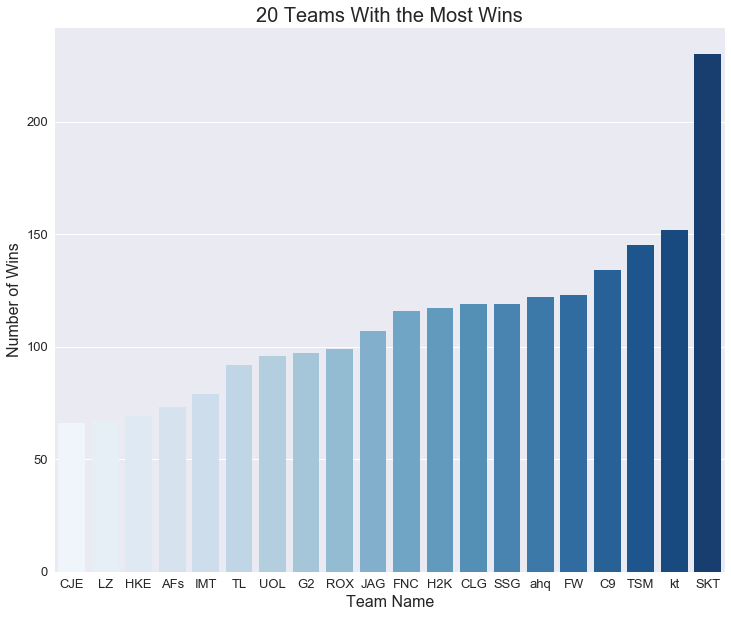

In [243]:
# sort wins for plotting
wins_df = wl_df[['team_name', 'wins']]
wins_df = wins_df.sort_values(by='wins')
wins_df = wins_df.tail(20)

# create plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='team_name', y='wins', palette='Blues', data=wins_df);
plt.title("20 Teams With the Most Wins",fontsize=20)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel("Team Name", fontsize=16)
plt.ylabel("Number of Wins", fontsize=16);

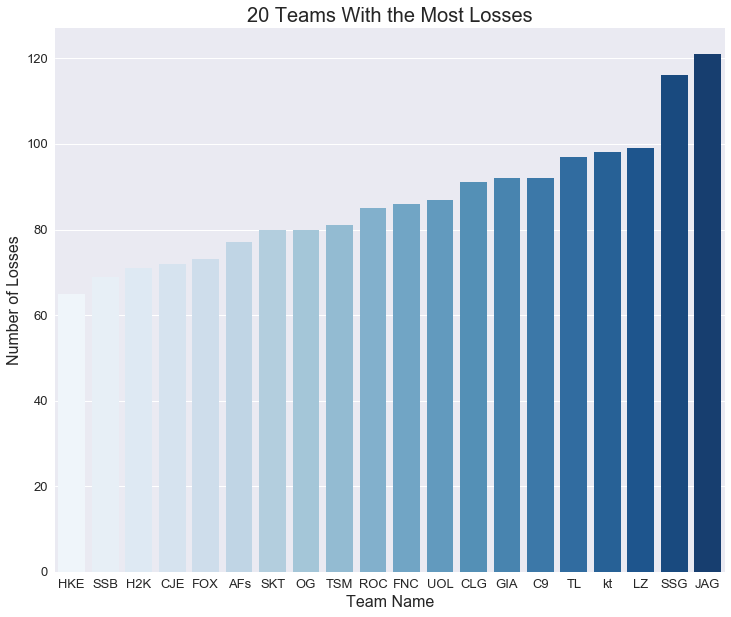

In [224]:
# sort losses for plotting
loss_df = wl_df[['team_name', 'losses']]
loss_df = loss_df.sort_values(by='losses')
loss_df = loss_df.tail(20)

# create plot
# create plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='team_name', y='losses', palette='Blues', data=loss_df);
plt.title("20 Teams With the Most Losses",fontsize=20)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel("Team Name", fontsize=16)
plt.ylabel("Number of Losses", fontsize=16);

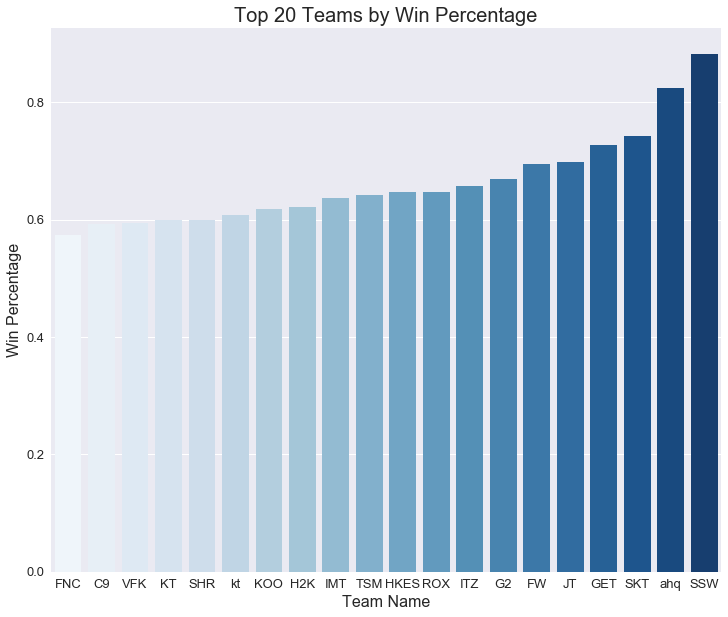

In [225]:
# sort losses for plotting
pct_df = wl_df[['team_name', 'win_pct']]
pct_df = pct_df.sort_values(by='win_pct')
pct_df = pct_df.tail(20)

# create plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='team_name', y='win_pct', palette='Blues', data=pct_df);
plt.title("Top 20 Teams by Win Percentage",fontsize=20)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel("Team Name", fontsize=16)
plt.ylabel("Win Percentage", fontsize=16);

# analysis

## Bans

introduction


In [226]:
# prepare ban data split across 5 column for aggregation
bans = gen_df[['year', 'ban_1', 'ban_2', 'ban_3', 'ban_4', 'ban_5']]
bans2 = gen_df[['ban_1', 'ban_2', 'ban_3', 'ban_4', 'ban_5']]

bans2 = bans2.rename(columns = {'ban_1':'ban1',
                                'ban_2':'ban2',
                                'ban_3':'ban3',
                                'ban_4':'ban4',
                                'ban_5':'ban5',})
bans_df = bans.join(bans2)

In [227]:
# obtain counts for each champion ban
bans_pt = pd.pivot_table(bans_df, index=['year', 'ban_1'], values=['ban1'], aggfunc='count').reset_index()
bans_pt = bans_pt.rename(columns={'ban_1':'champion'})

bans_pt2 = pd.pivot_table(bans_df, index=['year', 'ban_2'], values=['ban2'], aggfunc='count').reset_index()
bans_pt2 = bans_pt2.rename(columns={'ban_2':'champion'})

bans_pt3 = pd.pivot_table(bans_df, index=['year', 'ban_3'], values=['ban3'], aggfunc='count').reset_index()
bans_pt3 = bans_pt3.rename(columns={'ban_3':'champion'})

bans_pt4 = pd.pivot_table(bans_df, index=['year', 'ban_4'], values=['ban4'], aggfunc='count').reset_index()
bans_pt4 = bans_pt4.rename(columns={'ban_4':'champion'})

bans_pt5 = pd.pivot_table(bans_df, index=['year', 'ban_5'], values=['ban5'], aggfunc='count').reset_index()
bans_pt5 = bans_pt5.rename(columns={'ban_5':'champion'})

# join to one dataframe and get sum
pt_merged = pd.merge(bans_pt, bans_pt2, how='outer', left_on=['year','champion'], right_on=['year','champion'])
pt_merged = pd.merge(pt_merged, bans_pt3, how='outer', left_on=['year','champion'], right_on=['year','champion'])
pt_merged = pd.merge(pt_merged, bans_pt4, how='outer', left_on=['year','champion'], right_on=['year','champion'])
pt_merged = pd.merge(pt_merged, bans_pt5, how='outer', left_on=['year','champion'], right_on=['year','champion'])
pt_merged = pt_merged.fillna(0)
pt_merged['ban_sums'] = pt_merged.ban1 + pt_merged.ban2 + pt_merged.ban3 + pt_merged.ban4 + pt_merged.ban5
pt_merged = pt_merged[['year', 'champion', 'ban_sums']].sort_values(by=['year', 'ban_sums'])

In [228]:
# separate dataframes by year
df_14 = pt_merged.loc[pt_merged.year == 2014,:].tail(10)
df_15 = pt_merged.loc[pt_merged.year == 2015,:].tail(10)
df_16 = pt_merged.loc[pt_merged.year == 2016,:].tail(10)
df_17 = pt_merged.loc[pt_merged.year == 2017,:].tail(10)

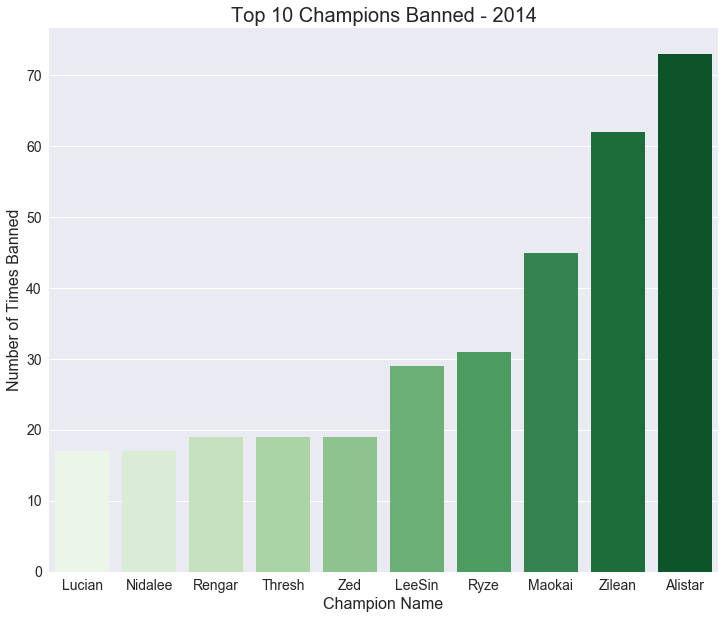

In [229]:
# create plot - most banned champion 2014
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='champion', y='ban_sums', palette=('Greens'), data=df_14);
plt.title("Top 10 Champions Banned - 2014",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Champion Name", fontsize=16)
plt.ylabel("Number of Times Banned", fontsize=16);

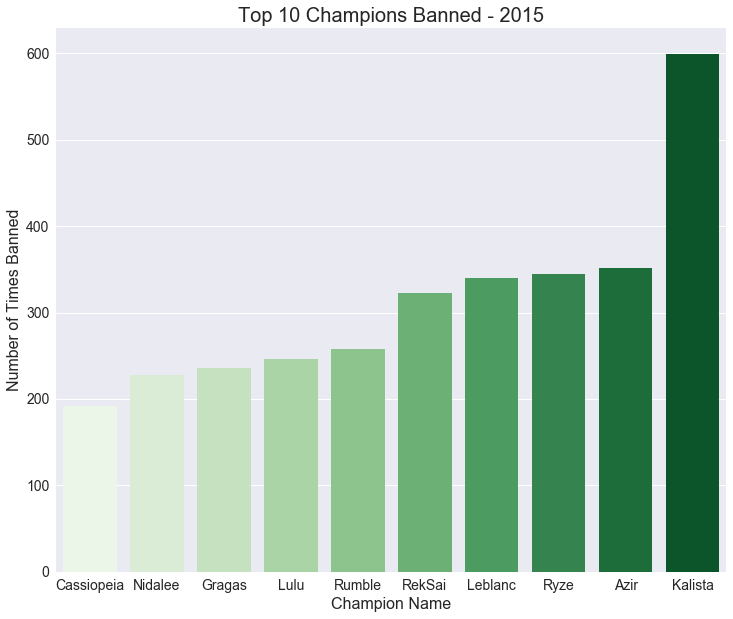

In [230]:
# create plot - most banned champion 2015
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='champion', y='ban_sums', palette='Greens', data=df_15);
plt.title("Top 10 Champions Banned - 2015",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Champion Name", fontsize=16)
plt.ylabel("Number of Times Banned", fontsize=16);

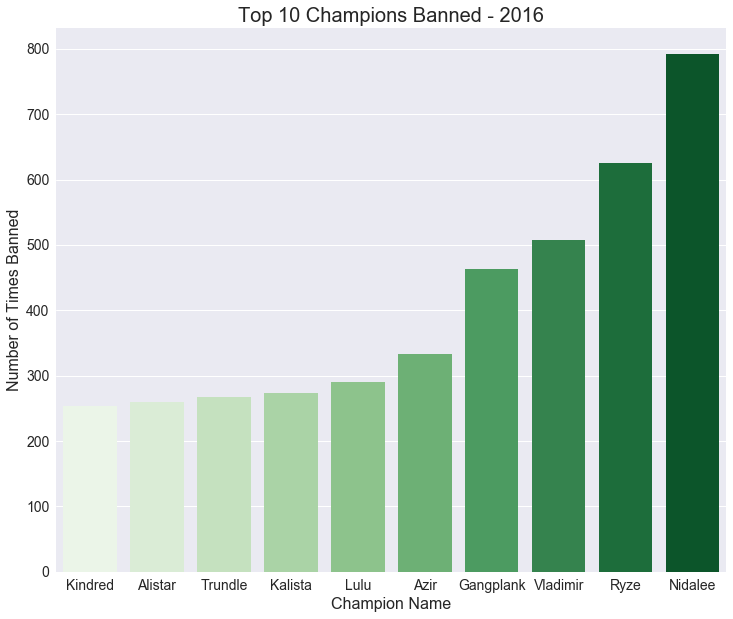

In [231]:
# create plot - most banned champion 2016
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='champion', y='ban_sums', palette='Greens', data=df_16);
plt.title("Top 10 Champions Banned - 2016",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Champion Name", fontsize=16)
plt.ylabel("Number of Times Banned", fontsize=16);

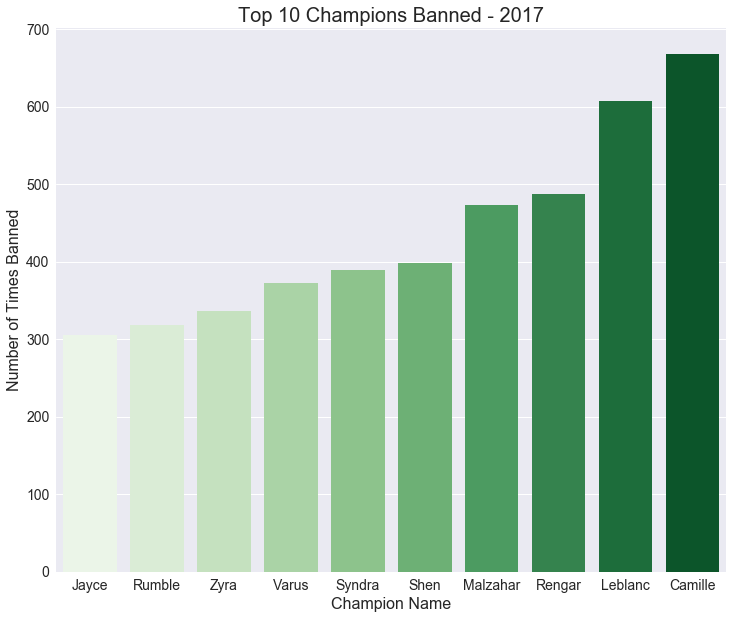

In [232]:
# create plot - most banned champion 2017
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='champion', y='ban_sums', palette='Greens', data=df_17);
plt.title("Top 10 Champions Banned - 2017",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Champion Name", fontsize=16)
plt.ylabel("Number of Times Banned", fontsize=16);

In [233]:
# obtain counts for each champion ban
bans_pt = pd.pivot_table(bans_df, index=['ban_1'], values=['ban1'], aggfunc='count').reset_index()
bans_pt = bans_pt.rename(columns={'ban_1':'champion'})

bans_pt2 = pd.pivot_table(bans_df, index=['ban_2'], values=['ban2'], aggfunc='count').reset_index()
bans_pt2 = bans_pt2.rename(columns={'ban_2':'champion'})

bans_pt3 = pd.pivot_table(bans_df, index=['ban_3'], values=['ban3'], aggfunc='count').reset_index()
bans_pt3 = bans_pt3.rename(columns={'ban_3':'champion'})

bans_pt4 = pd.pivot_table(bans_df, index=['ban_4'], values=['ban4'], aggfunc='count').reset_index()
bans_pt4 = bans_pt4.rename(columns={'ban_4':'champion'})

bans_pt5 = pd.pivot_table(bans_df, index=['ban_5'], values=['ban5'], aggfunc='count').reset_index()
bans_pt5 = bans_pt5.rename(columns={'ban_5':'champion'})

# join to one dataframe and get sum
pt_merged = pd.merge(bans_pt, bans_pt2, how='outer', left_on=['champion'], right_on=['champion'])
pt_merged = pd.merge(pt_merged, bans_pt3, how='outer', left_on=['champion'], right_on=['champion'])
pt_merged = pd.merge(pt_merged, bans_pt4, how='outer', left_on=['champion'], right_on=['champion'])
pt_merged = pd.merge(pt_merged, bans_pt5, how='outer', left_on=['champion'], right_on=['champion'])
pt_merged = pt_merged.fillna(0)
pt_merged['ban_sums'] = pt_merged.ban1 + pt_merged.ban2 + pt_merged.ban3 + pt_merged.ban4 + pt_merged.ban5
pt_merged = pt_merged[['champion', 'ban_sums']].sort_values(by=['ban_sums'])

In [234]:
overall_low = pt_merged.head(10)
overall_high = pt_merged.tail(10)

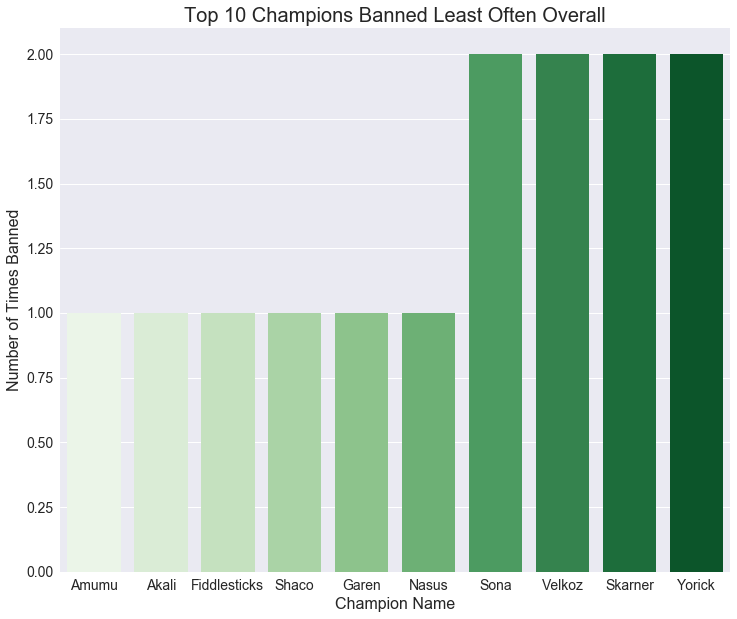

In [245]:
# create plot - most banned champion 2017
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='champion', y='ban_sums', palette='Greens', data=overall_low);
plt.title("Top 10 Champions Banned Least Often Overall",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Champion Name", fontsize=16)
plt.ylabel("Number of Times Banned", fontsize=16);

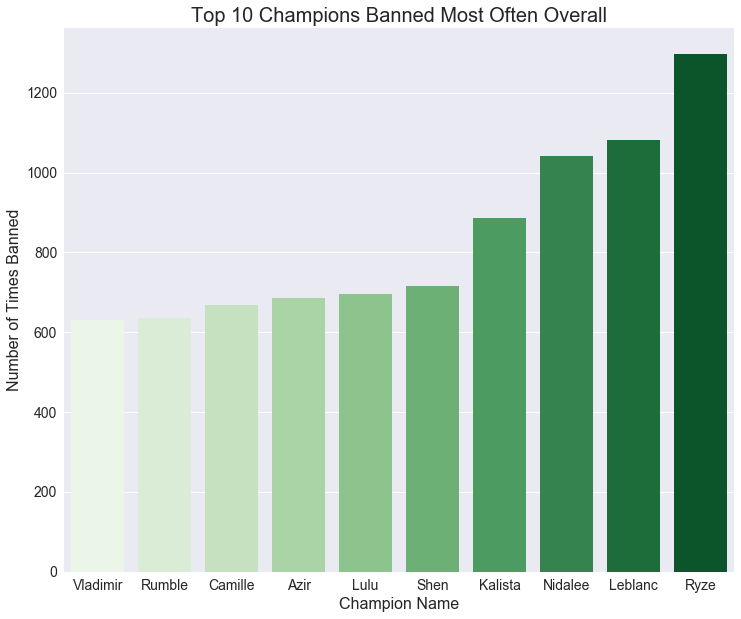

In [236]:
# create plot - most banned champion 2017
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='champion', y='ban_sums', palette='Greens', data=overall_high);
plt.title("Top 10 Champions Banned Most Often Overall",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Champion Name", fontsize=16)
plt.ylabel("Number of Times Banned", fontsize=16);

## Analysis

## Kills, Deaths and Assists

## Introduction

In [418]:
tk_df.head()

,match_id,red_or_blue_side,team_name,kills,deaths,assists,kda_ratio
0,001a1f289e3bab22,Blue,ANC,10.0,23.0,24.0,1.478261
1,001a1f289e3bab22,Red,CJE,23.0,10.0,56.0,7.900000
2,001f50c8547e2e73,Blue,EDG,28.0,10.0,60.0,8.800000
3,001f50c8547e2e73,Red,AHQ,10.0,28.0,23.0,1.178571
4,002f613ae09ad421,Blue,TPA,13.0,0.0,30.0,43.000000


In [419]:
tk_pt = pd.pivot_table(tk_df, index=['team_name'], values=['kda_ratio'], aggfunc=np.mean).reset_index().sort_values(by='kda_ratio')
tk_plot = tk_pt.tail(20)

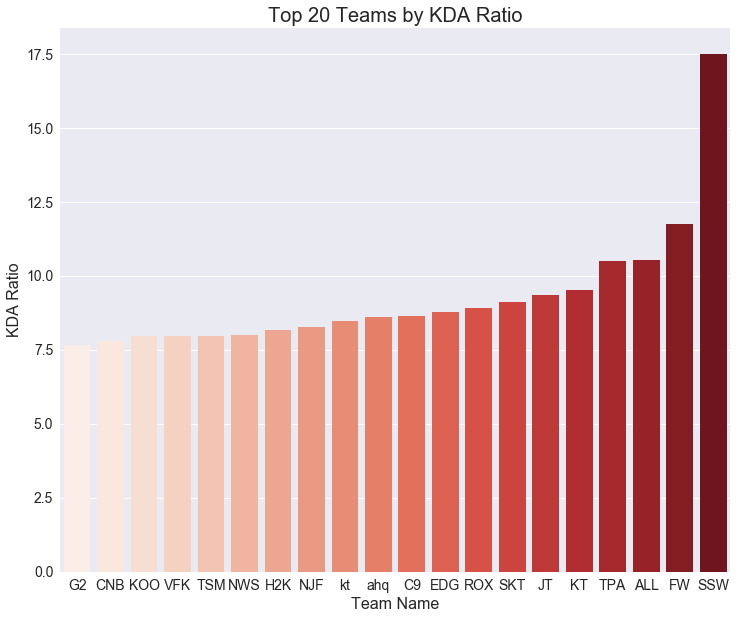

In [420]:
# create plot - most banned champion 2017
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='team_name', y='kda_ratio', palette='Reds', data=tk_plot);
plt.title("Top 20 Teams by KDA Ratio",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Team Name", fontsize=16)
plt.ylabel("KDA Ratio", fontsize=16);

## Individual players

In [421]:
pk_df.head()

,match_id,team_name,player,kills,deaths,assists,kda_ratio
0,001a1f289e3bab22,ANC,SnowFlower,1,4,6,1.750000
1,001a1f289e3bab22,ANC,ikssu,1,3,4,1.666667
2,001a1f289e3bab22,ANC,lira,1,7,6,1.000000
3,001a1f289e3bab22,CJE,Ambition,4,2,12,8.000000
4,001a1f289e3bab22,CJE,Coco,8,2,10,9.000000


In [422]:
# get number of games played
pk_pt2 = pd.pivot_table(pk_df, index=['player'], values= 'kda_ratio', aggfunc='count').reset_index().sort_values(by='kda_ratio')
# players with the most games played
pk_pt2.tail(10)

,player,kda_ratio
287,Kuro,243
525,Ssumday,248
414,PraY,252
40,Arrow,259
205,GorillA,259
505,Smeb,260
480,Score,260
164,Faker,272
613,Wolf,298
52,Bang,310


In [423]:
pk_pt = pd.pivot_table(pk_df, index=['player'], values= 'kda_ratio', aggfunc=np.mean).reset_index().sort_values(by='kda_ratio')
pk_merge = pd.merge(pk_pt2, pk_pt, on='player')
pk_merge = pk_merge.loc[pk_merge['kda_ratio_x'] >= 40,:]
pk_merge = pk_merge.sort_values(by='kda_ratio_y')
pk_plot = pk_merge.tail(20)

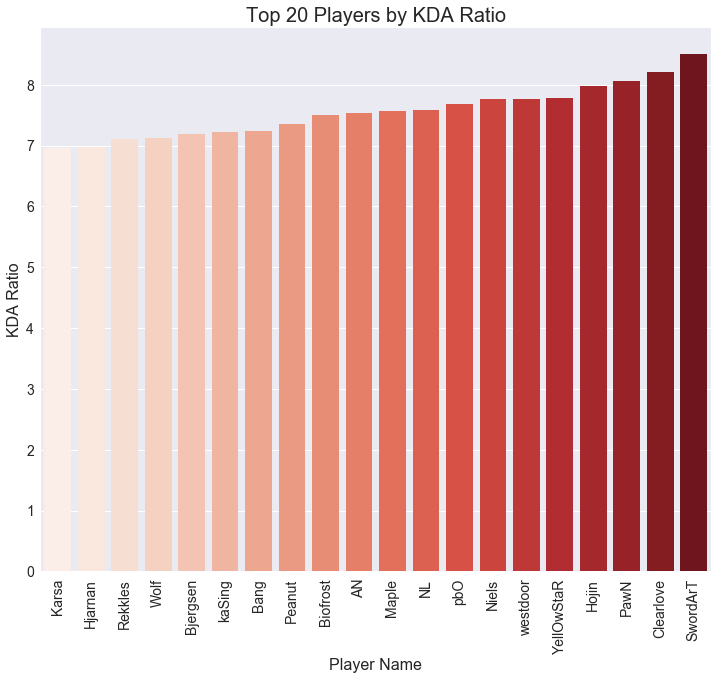

In [424]:
# create plot - most banned champion 2017
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='player', y='kda_ratio_y', palette='Reds', data=pk_plot);
plt.title("Top 20 Players by KDA Ratio",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(rotation=90)
plt.xlabel("Player Name", fontsize=16)
plt.ylabel("KDA Ratio", fontsize=16);

## Positional KDA Ratios

In [425]:
# get series of each player's position
top = gen_df.loc[:,'top_player']
jgl = gen_df.loc[:,'jungle_player']
mid = gen_df.loc[:,'mid_player']
adc = gen_df.loc[:,'adc_player']
sup = gen_df.loc[:,'support_player']

In [426]:
# create dataframes for each position
top_df = pk_df.loc[pk_df.player.isin(top),:]
jgl_df = pk_df.loc[pk_df.player.isin(jgl),:]
mid_df = pk_df.loc[pk_df.player.isin(mid),:]
adc_df = pk_df.loc[pk_df.player.isin(adc),:]
sup_df = pk_df.loc[pk_df.player.isin(sup),:]

In [427]:
# get number of games played
top_pt = pd.pivot_table(top_df, index=['player'], values= 'kda_ratio', aggfunc='count').reset_index().sort_values(by='kda_ratio')

# average kda_ratio
top_pt2 = pd.pivot_table(top_df, index=['player'], values= 'kda_ratio', aggfunc=np.mean).reset_index().sort_values(by='kda_ratio')

# create dataframe with top 20 players
top_merge = pd.merge(top_pt2, top_pt, on='player')
top_merge = top_merge.loc[top_merge['kda_ratio_y'] >= 40,:]
top_merge = top_merge.sort_values(by='kda_ratio_x')
top_plot = top_merge.tail(20)

In [428]:
# get number of games played
jgl_pt = pd.pivot_table(jgl_df, index=['player'], values= 'kda_ratio', aggfunc='count').reset_index().sort_values(by='kda_ratio')

# average kda_ratio
jgl_pt2 = pd.pivot_table(jgl_df, index=['player'], values= 'kda_ratio', aggfunc=np.mean).reset_index().sort_values(by='kda_ratio')

# create dataframe with top 20 players
jgl_merge = pd.merge(jgl_pt2, jgl_pt, on='player')
jgl_merge = jgl_merge.loc[jgl_merge['kda_ratio_y'] >= 40,:]
jgl_merge = jgl_merge.sort_values(by='kda_ratio_x')
jgl_plot = jgl_merge.tail(20)

In [429]:
# get number of games played
mid_pt = pd.pivot_table(mid_df, index=['player'], values= 'kda_ratio', aggfunc='count').reset_index().sort_values(by='kda_ratio')

# average kda_ratio
mid_pt2 = pd.pivot_table(mid_df, index=['player'], values= 'kda_ratio', aggfunc=np.mean).reset_index().sort_values(by='kda_ratio')

# create dataframe with top 20 players
mid_merge = pd.merge(mid_pt2, mid_pt, on='player')
mid_merge = mid_merge.loc[mid_merge['kda_ratio_y'] >= 40,:]
mid_merge = mid_merge.sort_values(by='kda_ratio_x')
mid_plot = mid_merge.tail(20)

In [430]:
# get number of games played
adc_pt = pd.pivot_table(adc_df, index=['player'], values= 'kda_ratio', aggfunc='count').reset_index().sort_values(by='kda_ratio')

# average kda_ratio
adc_pt2 = pd.pivot_table(adc_df, index=['player'], values= 'kda_ratio', aggfunc=np.mean).reset_index().sort_values(by='kda_ratio')

# create dataframe with top 20 players
adc_merge = pd.merge(adc_pt2, adc_pt, on='player')
adc_merge = adc_merge.loc[adc_merge['kda_ratio_y'] >= 40,:]
adc_merge = adc_merge.sort_values(by='kda_ratio_x')
adc_plot = adc_merge.tail(20)

In [431]:
# get number of games played
sup_pt = pd.pivot_table(sup_df, index=['player'], values= 'kda_ratio', aggfunc='count').reset_index().sort_values(by='kda_ratio')

# average kda_ratio
sup_pt2 = pd.pivot_table(sup_df, index=['player'], values= 'kda_ratio', aggfunc=np.mean).reset_index().sort_values(by='kda_ratio')

# create dataframe with top 20 players
sup_merge = pd.merge(sup_pt2, sup_pt, on='player')
sup_merge = sup_merge.loc[sup_merge['kda_ratio_y'] >= 40,:]
sup_merge = sup_merge.sort_values(by='kda_ratio_x')
sup_plot = sup_merge.tail(20)

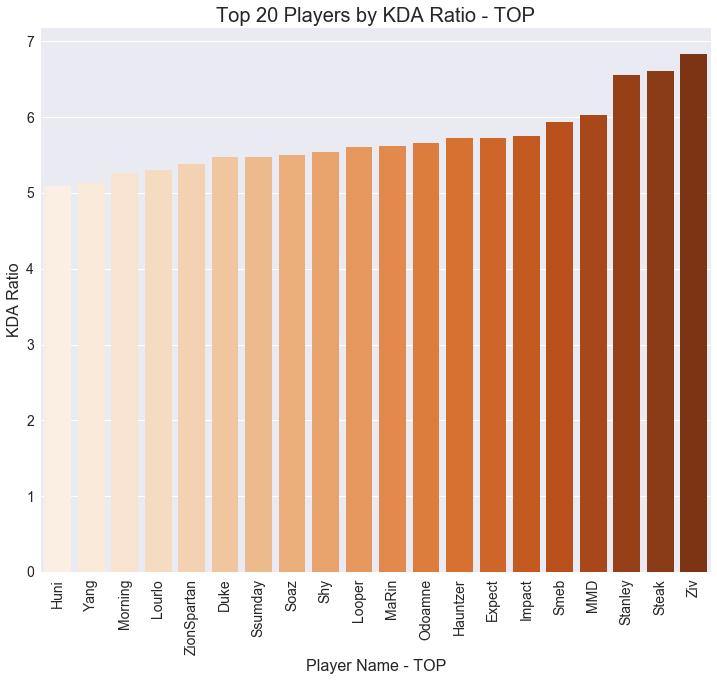

In [452]:
# create plot - top
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='player', y='kda_ratio_x', palette='Oranges', data=top_plot);
plt.title("Top 20 Players by KDA Ratio - TOP",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(rotation=90)
plt.xlabel("Player Name - TOP", fontsize=16)
plt.ylabel("KDA Ratio", fontsize=16);

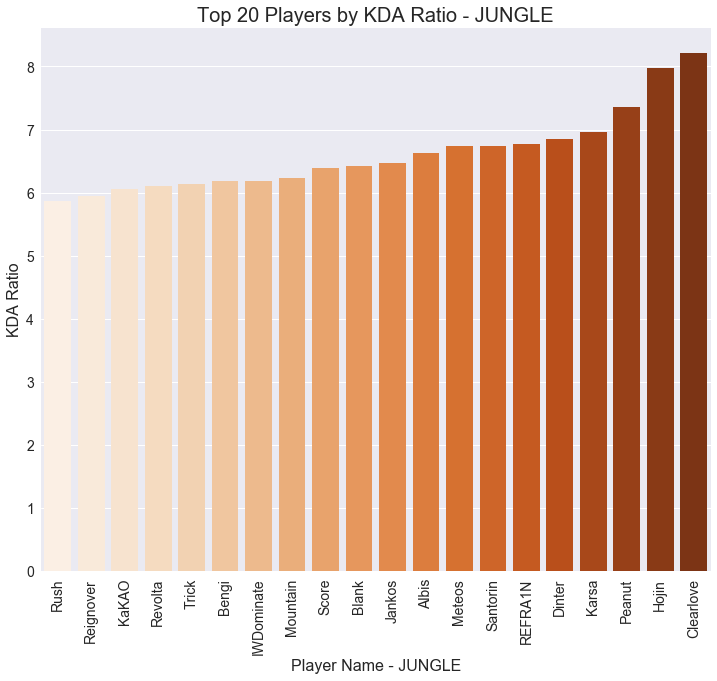

In [453]:
# create plot - top
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='player', y='kda_ratio_x', palette='Oranges', data=jgl_plot);
plt.title("Top 20 Players by KDA Ratio - JUNGLE",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(rotation=90)
plt.xlabel("Player Name - JUNGLE", fontsize=16)
plt.ylabel("KDA Ratio", fontsize=16);

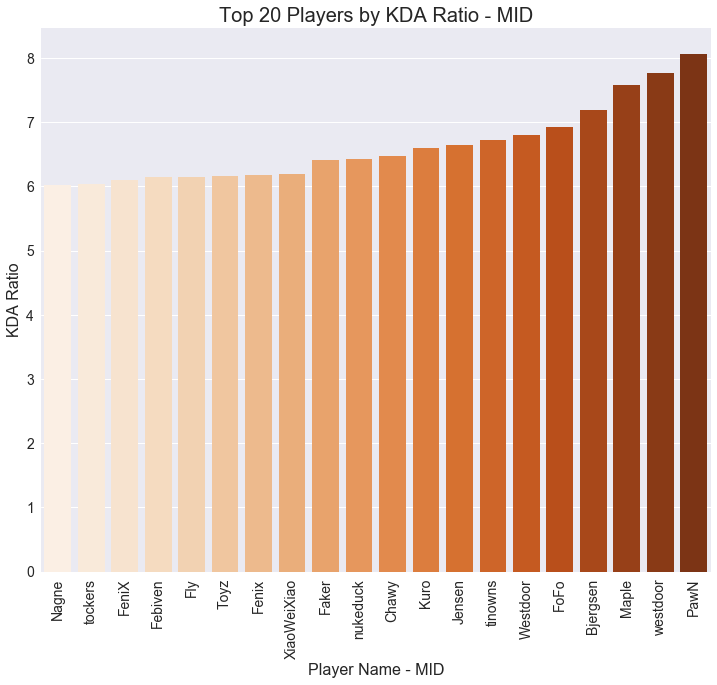

In [454]:
# create plot - top
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='player', y='kda_ratio_x', palette='Oranges', data=mid_plot);
plt.title("Top 20 Players by KDA Ratio - MID",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(rotation=90)
plt.xlabel("Player Name - MID", fontsize=16)
plt.ylabel("KDA Ratio", fontsize=16);

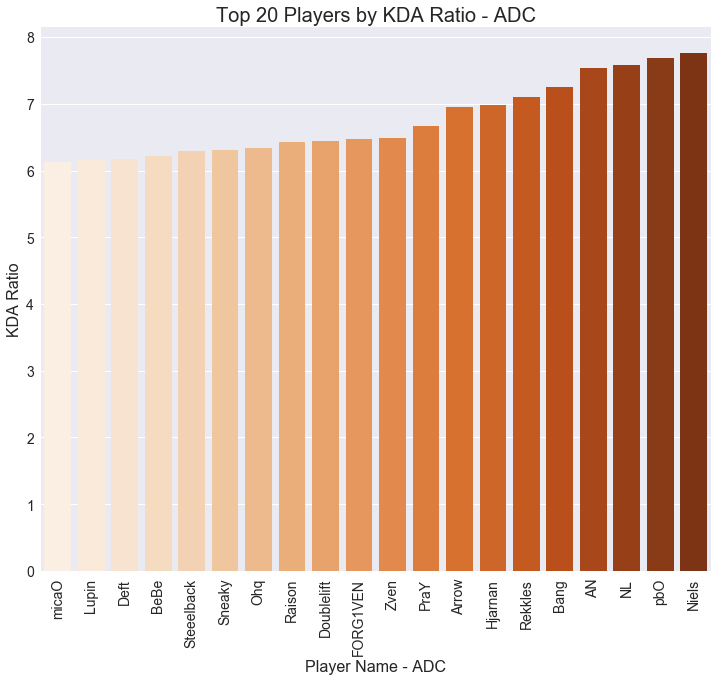

In [455]:
# create plot - top
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='player', y='kda_ratio_x', palette='Oranges', data=adc_plot);
plt.title("Top 20 Players by KDA Ratio - ADC",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(rotation=90)
plt.xlabel("Player Name - ADC", fontsize=16)
plt.ylabel("KDA Ratio", fontsize=16);

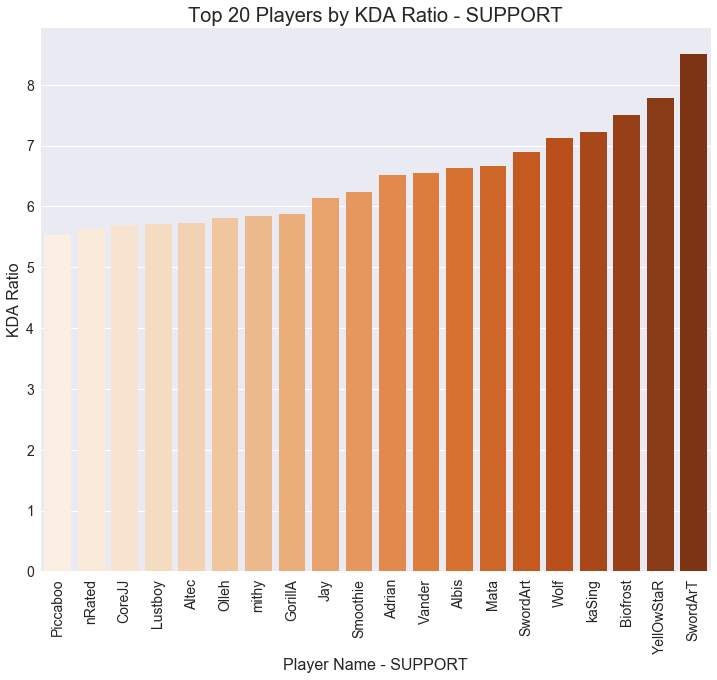

In [456]:
# create plot - top
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='player', y='kda_ratio_x', palette='Oranges', data=sup_plot);
plt.title("Top 20 Players by KDA Ratio - SUPPORT",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(rotation=90)
plt.xlabel("Player Name - SUPPORT", fontsize=16)
plt.ylabel("KDA Ratio", fontsize=16);

## Most Kills, Deaths and Assists

In [437]:
kills_df = pk_df[['player', 'kills']]
kills_df = kills_df.sort_values('kills')
kills_plot = kills_df.tail(20)

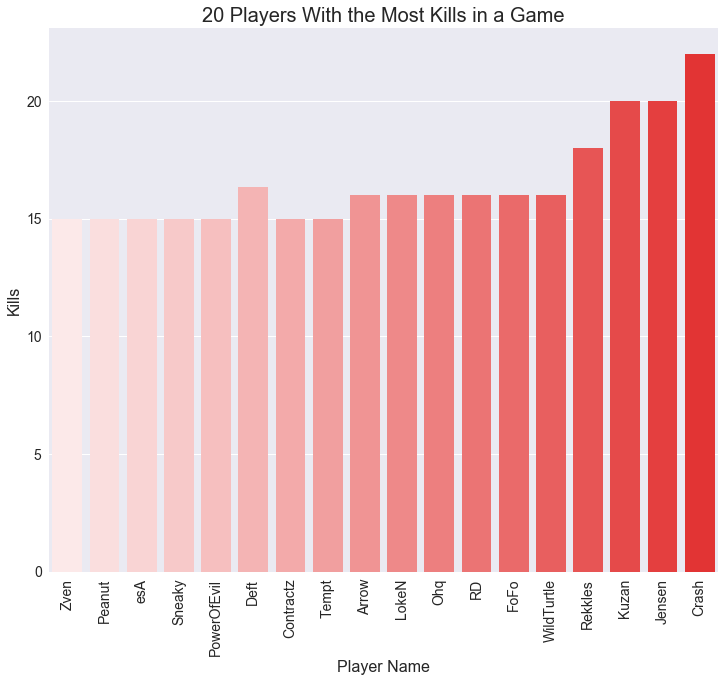

In [448]:
# create plot - top
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
pal = sns.light_palette('red', 20)
sns.barplot(x='player', y='kills', palette=pal, data=kills_plot, ci=None);
plt.title("20 Players With the Most Kills in a Game",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(rotation=90)
plt.xlabel("Player Name", fontsize=16)
plt.ylabel("Kills", fontsize=16);

In [439]:
deaths_df = pk_df[['player', 'deaths']]
deaths_df = deaths_df.sort_values('deaths')
deaths_plot = deaths_df.tail(20)

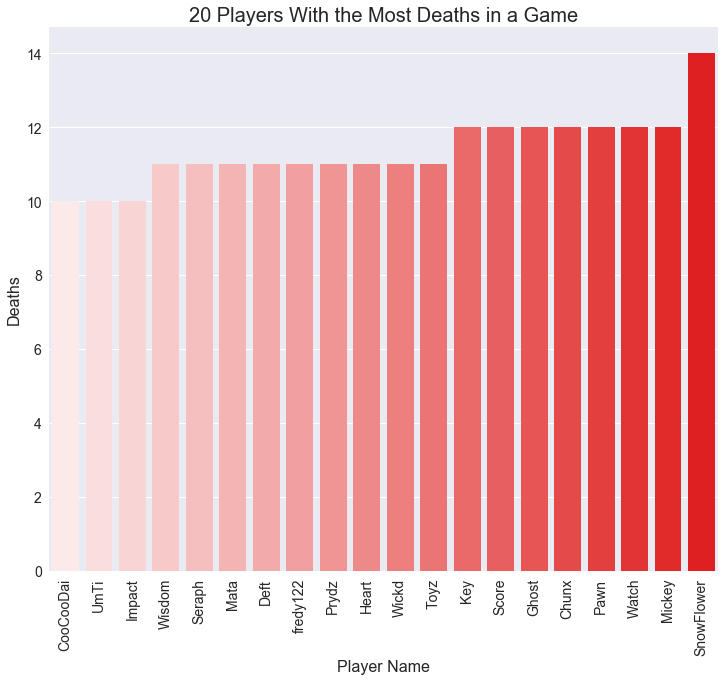

In [447]:
# create plot - top
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
pal = sns.light_palette('red', 20)
sns.barplot(x='player', y='deaths', palette=pal, data=deaths_plot);
plt.title("20 Players With the Most Deaths in a Game",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(rotation=90)
plt.xlabel("Player Name", fontsize=16)
plt.ylabel("Deaths", fontsize=16);

In [441]:
assists_df = pk_df[['player', 'assists']]
assists_df = assists_df.sort_values('assists')
assists_plot = assists_df.tail(20)

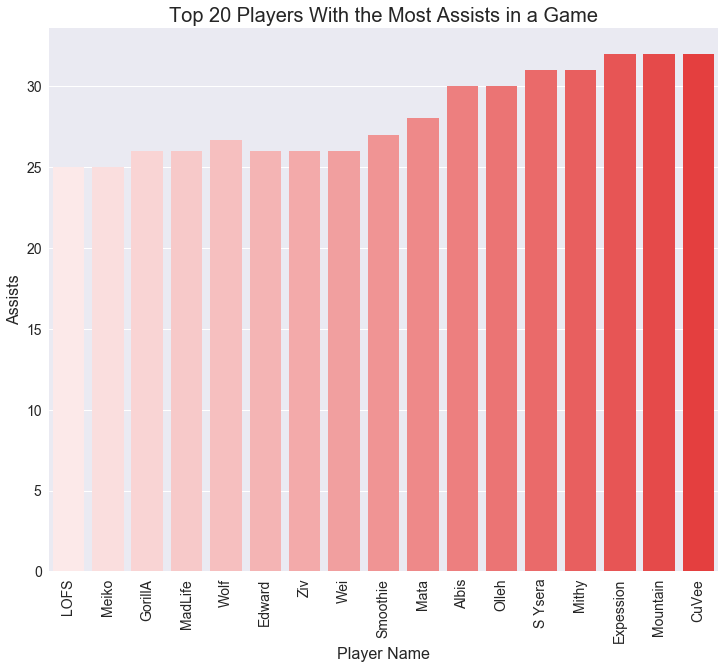

In [446]:
# create plot - top
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
pal = sns.light_palette('red', 20)
sns.barplot(x='player', y='assists', palette=pal, data=assists_plot, ci=None);
plt.title("Top 20 Players With the Most Assists in a Game",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(rotation=90)
plt.xlabel("Player Name", fontsize=16)
plt.ylabel("Assists", fontsize=16);

# Gold Totals

Introduction

In [457]:
gt_df.head()

,match_id,league,season,year,team_name,red_or_blue_side,result,game_length,type,player_name,champion,min_0,min_1,min_2,min_3,min_4,min_5,min_6,min_7,min_8,min_9,min_10,min_11,min_12,min_13,min_14,min_15,min_16,min_17,min_18,min_19,min_20,min_21,min_22,min_23,min_24,min_25,min_26,min_27,min_28,min_29,min_30,min_31,min_32,min_33,min_34,min_35,min_36,min_37,min_38,min_39,min_40,min_41,min_42,min_43,min_44,min_45,min_46,min_47,min_48,min_49,min_50,min_51,min_52,min_53,min_54,min_55,min_56,min_57,min_58,min_59,min_60,min_61,min_62,min_63,min_64,min_65,min_66,min_67,min_68,min_69,min_70,min_71,min_72,min_73,min_74,min_75,min_76,min_77,min_78,min_79,min_80
0,001a1f289e3bab22,LCK,Summer_Season,2015,ANC,blue,0,38,total_gold,NaN,NaN,2415,2430,2751,3929,5219,6418,8156,9520,10681,12036,13678,15590,16782,18417,20052,21608,23396,24248,25691,27452.0,30446.0,31672.0,33665.0,36399.0,37571.0,38659.0,39757.0,41498.0,42861.0,44378.0,45719.0,47095.0,48551.0,49524.0,51200.0,52518.0,53247.0,53893.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,001a1f289e3bab22,LCK,Summer_Season,2015,CJE,red,1,38,total_gold,NaN,NaN,2415,2415,2705,4062,5279,7322,8661,10372,11444,13260,14676,15723,18119,19663,21237,22809,24997,28072,30162,31469.0,32490.0,34362.0,36662.0,37981.0,39398.0,40331.0,41652.0,44239.0,45948.0,47134.0,49334.0,51052.0,52586.0,53374.0,55245.0,56618.0,62198.0,62846.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,001f50c8547e2e73,Season_World_Championship,International,2014,EDG,blue,1,37,total_gold,NaN,NaN,2415,2415,2705,3817,4956,6132,7499,8605,9942,11434,13028,15942,17653,19941,21320,23236,24835,26384,29350,32365.0,33752.0,35258.0,39070.0,40973.0,42591.0,45637.0,46672.0,48001.0,49458.0,51181.0,52245.0,54233.0,58476.0,61061.0,62324.0,65435.0,69584.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001f50c8547e2e73,Season_World_Championship,International,2014,AHQ,red,0,37,total_gold,NaN,NaN,2415,2415,2705,3728,5048,6306,7308,8536,9689,11072,12952,13978,15289,16639,18575,19558,22343,23318,24585,25342.0,26616.0,27778.0,29198.0,30997.0,32647.0,34549.0,35535.0,36591.0,38024.0,39272.0,40585.0,41883.0,42547.0,43836.0,45798.0,46951.0,47804.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,002f613ae09ad421,LMS,Spring_Season,2016,TPA,blue,1,30,total_gold,NaN,NaN,2500,2500,2785,4216,6193,7618,9674,11203,13004,14497,15653,17089,19084,20938,22437,24228,27072,28475,31466,34244.0,37178.0,39046.0,41074.0,42978.0,44964.0,48148.0,49707.0,51624.0,54594.0,56268.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [484]:
# select only the games from 2016 World Championships
champ_df = gt_df.loc[(gt_df['league'] == 'Season_World_Championship') &
                      (gt_df['year'] == 2016) & (gt_df['type'] == 'total_gold'),:]

# the finals were played by SKT and SSG
finals_df = champ_df.loc[(champ_df['team_name'] == 'SSG') | (champ_df['team_name'] == 'SKT'),:]

In [618]:
# select only the 5 games from the finals
fin_df = finals_df.loc[(finals_df['match_id'] == '473fc1deff74591b') |
                      (finals_df['match_id'] == '2a1d6285ce9dd71f') |
                      (finals_df['match_id'] == '6ca759012b24b8b1') |
                      (finals_df['match_id'] == 'ac33fc72f78724a8') |
                      (finals_df['match_id'] == 'e5af5592e36bdb01'),:]
fin_df

,match_id,league,season,year,team_name,red_or_blue_side,result,game_length,type,player_name,champion,min_0,min_1,min_2,min_3,min_4,min_5,min_6,min_7,min_8,min_9,min_10,min_11,min_12,min_13,min_14,min_15,min_16,min_17,min_18,min_19,min_20,min_21,min_22,min_23,min_24,min_25,min_26,min_27,min_28,min_29,min_30,min_31,min_32,min_33,min_34,min_35,min_36,min_37,min_38,min_39,min_40,min_41,min_42,min_43,min_44,min_45,min_46,min_47,min_48,min_49,min_50,min_51,min_52,min_53,min_54,min_55,min_56,min_57,min_58,min_59,min_60,min_61,min_62,min_63,min_64,min_65,min_66,min_67,min_68,min_69,min_70,min_71,min_72,min_73,min_74,min_75,min_76,min_77,min_78,min_79,min_80
1222,2a1d6285ce9dd71f,Season_World_Championship,International,2016,SKT,blue,0,47,total_gold,NaN,NaN,2500,2500,2797,4235,5685,7068,8471,9869,11214,12622,14220,15670,17167,18746,20428,22024,23489,24690,26518,28394.0,30574.0,32396.0,34122.0,35950.0,37934.0,39949.0,41397.0,43745.0,46155.0,48132.0,50799.0,52535.0,54365.0,55646.0,57384.0,58507.0,61254.0,63522.0,65195.0,67318.0,69274.0,71373.0,73437.0,75583.0,77319.0,78436.0,79438.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1223,2a1d6285ce9dd71f,Season_World_Championship,International,2016,SSG,red,1,47,total_gold,NaN,NaN,2500,2508,2730,4190,5780,7002,8615,9878,11406,12885,14445,15773,17453,18835,20448,22160,23655,25867,27694,30385.0,31806.0,33912.0,35687.0,37433.0,39309.0,41150.0,43159.0,44474.0,46042.0,47369.0,49141.0,50856.0,52337.0,56567.0,58778.0,63594.0,65179.0,66527.0,70150.0,71405.0,74360.0,75741.0,78141.0,79577.0,80764.0,83840.0,88011.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2077,473fc1deff74591b,Season_World_Championship,International,2016,SKT,blue,1,32,total_gold,NaN,NaN,2500,2527,2699,4081,5450,6671,8051,9433,10903,12515,14030,15925,17597,20003,21382,24049,26376,28012,30863,32871.0,35147.0,37014.0,39542.0,41165.0,43748.0,45508.0,47480.0,50408.0,52096.0,56062.0,58580.0,62644.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2076,473fc1deff74591b,Season_World_Championship,International,2016,SSG,red,0,32,total_gold,NaN,NaN,2500,2527,2749,4340,5989,7479,8820,10392,12051,13620,15235,16454,18136,20232,21593,22766,24471,25992,27495,30230.0,31933.0,33049.0,34795.0,36364.0,37745.0,39045.0,40714.0,42156.0,43357.0,44578.0,46122.0,46926.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3204,6ca759012b24b8b1,Season_World_Championship,International,2016,SSG,blue,1,72,total_gold,NaN,NaN,2500,2500,2808,4262,5833,7027,8623,10129,11580,12816,14253,15465,17135,18572,20072,21497,23329,24804,26472,28310.0,29734.0,31369.0,33536.0,35187.0,36897.0,38092.0,39860.0,41711.0,43463.0,45419.0,47930.0,51455.0,54307.0,56731.0,60101.0,61449.0,62917.0,64788.0,66398.0,68053.0,69816.0,71299.0,73164.0,74615.0,75915.0,77848.0,79184.0,80548.0,82079.0,83439.0,84667.0,87503.0,89614.0,91001.0,92422.0,94508.0,96914.0,98223.0,100728.0,101940.0,103403.0,105120.0,107174.0,108314.0,110217.0,111769.0,113142.0,114680.0,117319.0,118714.0,121885.0,124522.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3205,6ca759012b24b8b1,Season_World_Championship,International,2016,SKT,red,0,72,total_gold,NaN,NaN,2500,2500,2774,4142,5744,7226,8768,10148,11620,13541,14870,16397,17973,19639,21676,23052,24916,26505,28132,30993.0,33341.0,35836.0,38807.0,41099.0,42936.0,46844.0,48463.0,50422.0,52591.0,54260.0,55261.0,56677.0,57962.0,59841.0,61638.0,64017.0,65864.0,67651.0,70274.0,72190.0,73909.0,75341.0,76598.0,77626.0,79619.0,81525.0,82800.0,84424.0,85895.0,87503.0,90082.0,92940.0,94322.0,96249.0,98170.0,99629.0,101074.0,103274.

In [628]:
# prepare data for graphing
game1 = fin_df.loc[(fin_df['match_id'] == 'e5af5592e36bdb01'),:]
game1 = game1.drop(['match_id', 'league', 'season', 'year', 'red_or_blue_side', 'result', 'game_length', 'type', 
            'player_name', 'champion'], axis=1)
game1 = game1.fillna(0)

# transpose data and rename columns 
game1 = game1.drop('team_name', axis=1)
game1 = game1.T
game1 = game1.rename(columns = {6814:'SSG',6815:'SKT'})

# only select rows where the game is being played
# after the game ends the values are NaN (0)
game1 = game1.loc[(game1['SKT'] != 0),:]

In [641]:
# create date time object
time = pd.date_range("0:00", "0:54", freq="1min", format='%H:%M')

# append to dataframe
game1['time'] = time
game1['time_m'] = game1['time'].dt.time

# set as index
game1 = game1.set_index('time_m')
game1 = game1.drop('time', axis=1)

In [645]:
# prepare data for graphing
game2 = fin_df.loc[(fin_df['match_id'] == '473fc1deff74591b'),:]
game2 = game2.drop(['match_id', 'league', 'season', 'year', 'red_or_blue_side', 'result', 'game_length', 'type', 
            'player_name', 'champion'], axis=1)
game2 = game2.fillna(0)

# transpose data and rename columns 
game2 = game2.drop('team_name', axis=1)
game2 = game2.T
game2 = game2.rename(columns = {2077:'SKT',2076:'SSG'})

# only select rows where the game is being played
# after the game ends the values are NaN (0)
game2 = game2.loc[(game2['SKT'] != 0),:]

In [646]:
# create date time object
time = pd.date_range("0:00", "0:31", freq="1min", format='%H:%M')

# append to dataframe
game2['time'] = time
game2['time_m'] = game2['time'].dt.time

# set as index
game2 = game2.set_index('time_m')
game2 = game2.drop('time', axis=1)

In [622]:
# prepare data for graphing
game3 = fin_df.loc[(fin_df['match_id'] == '6ca759012b24b8b1'),:]
game3 = game3.drop(['match_id', 'league', 'season', 'year', 'red_or_blue_side', 'result', 'game_length', 'type', 
            'player_name', 'champion'], axis=1)
game3 = game3.fillna(0)

# transpose data and rename columns 
game3 = game3.drop('team_name', axis=1)
game3 = game3.T
game3 = game3.rename(columns = {3205:'SKT',3204:'SSG'})

# only select rows where the game is being played
# after the game ends the values are NaN (0)
game3 = game3.loc[(game3['SKT'] != 0),:]

In [649]:
# create date time object
time = pd.date_range("0:00", "1:11", freq="1min", format='%H:%M')

# append to dataframe
game3['time'] = time
game3['time_m'] = game3['time'].dt.time

# set as index
game3 = game3.set_index('time_m')
game3 = game3.drop('time', axis=1)

In [654]:
# prepare data for graphing
game4 = fin_df.loc[(fin_df['match_id'] == '2a1d6285ce9dd71f'),:]
game4 = game4.drop(['match_id', 'league', 'season', 'year', 'red_or_blue_side', 'result', 'game_length', 'type', 
            'player_name', 'champion'], axis=1)
game4 = game4.fillna(0)

# transpose data and rename columns 
game4 = game4.drop('team_name', axis=1)
game4 = game4.T
game4 = game4.rename(columns = {1222:'SKT',1223:'SSG'})

# only select rows where the game is being played
# after the game ends the values are NaN (0)
game4 = game4.loc[(game4['SKT'] != 0),:]

In [656]:
# create date time object
time = pd.date_range("0:00", "0:46", freq="1min", format='%H:%M')

# append to dataframe
game4['time'] = time
game4['time_m'] = game4['time'].dt.time

# set as index
game4 = game4.set_index('time_m')
game4 = game4.drop('time', axis=1)

In [659]:
# prepare data for graphing
game5 = fin_df.loc[(fin_df['match_id'] == 'ac33fc72f78724a8'),:]
game5 = game5.drop(['match_id', 'league', 'season', 'year', 'red_or_blue_side', 'result', 'game_length', 'type', 
            'player_name', 'champion'], axis=1)
game5 = game5.fillna(0)

# transpose data and rename columns 
game5 = game5.drop('team_name', axis=1)
game5 = game5.T
game5 = game5.rename(columns = {5090:'SKT',5091:'SSG'})

# only select rows where the game is being played
# after the game ends the values are NaN (0)
game5 = game5.loc[(game5['SKT'] != 0),:]

In [660]:
# create date time object
time = pd.date_range("0:00", "0:49", freq="1min", format='%H:%M')

# append to dataframe
game5['time'] = time
game5['time_m'] = game5['time'].dt.time

# set as index
game5 = game5.set_index('time_m')
game5 = game5.drop('time', axis=1)

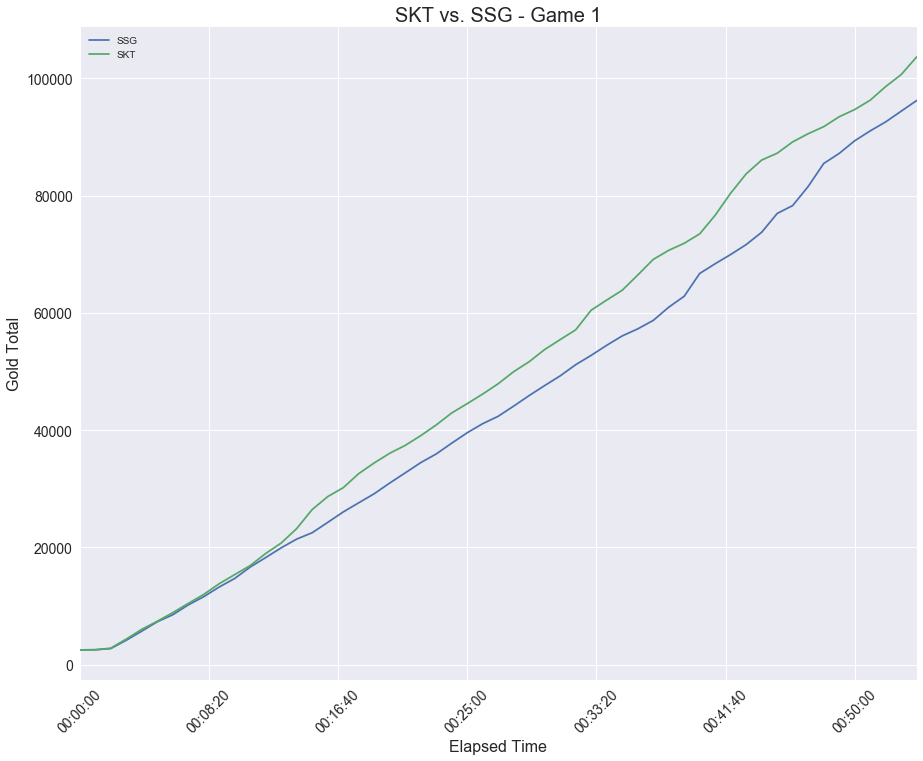

In [670]:
# create plot
game1.plot(figsize=(15,12))
plt.title("SKT vs. SSG - Game 1",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(rotation=45)
plt.xlabel("Elapsed Time", fontsize=16)
plt.ylabel("Gold Total", fontsize=16);

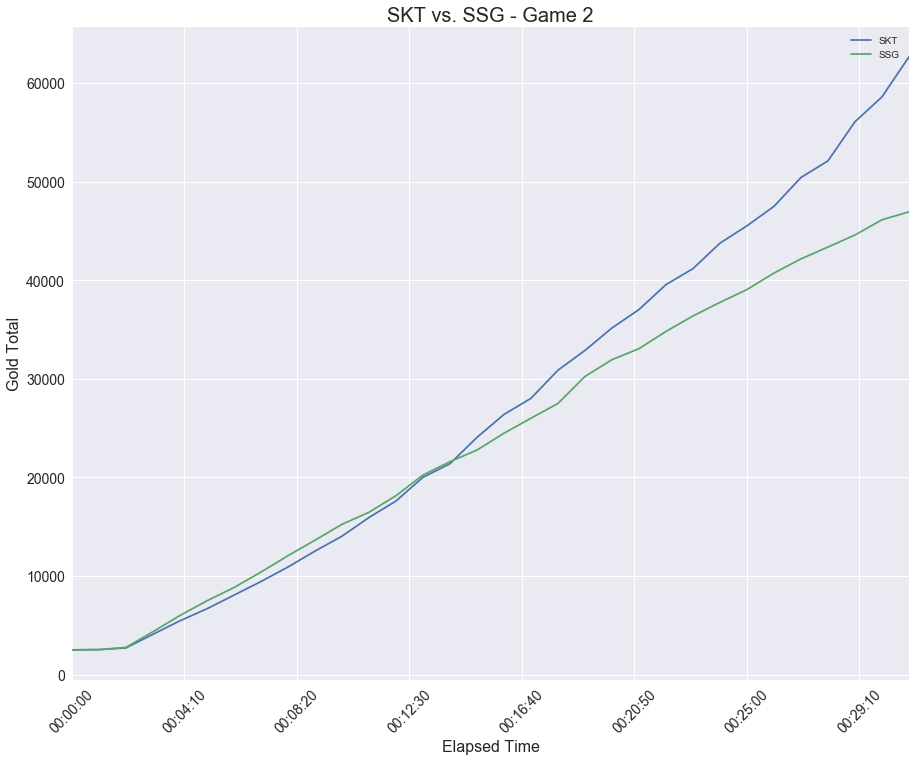

In [669]:
# create plot
game2.plot(figsize=(15,12))
plt.title("SKT vs. SSG - Game 2",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(rotation=45)
plt.xlabel("Elapsed Time", fontsize=16)
plt.ylabel("Gold Total", fontsize=16);

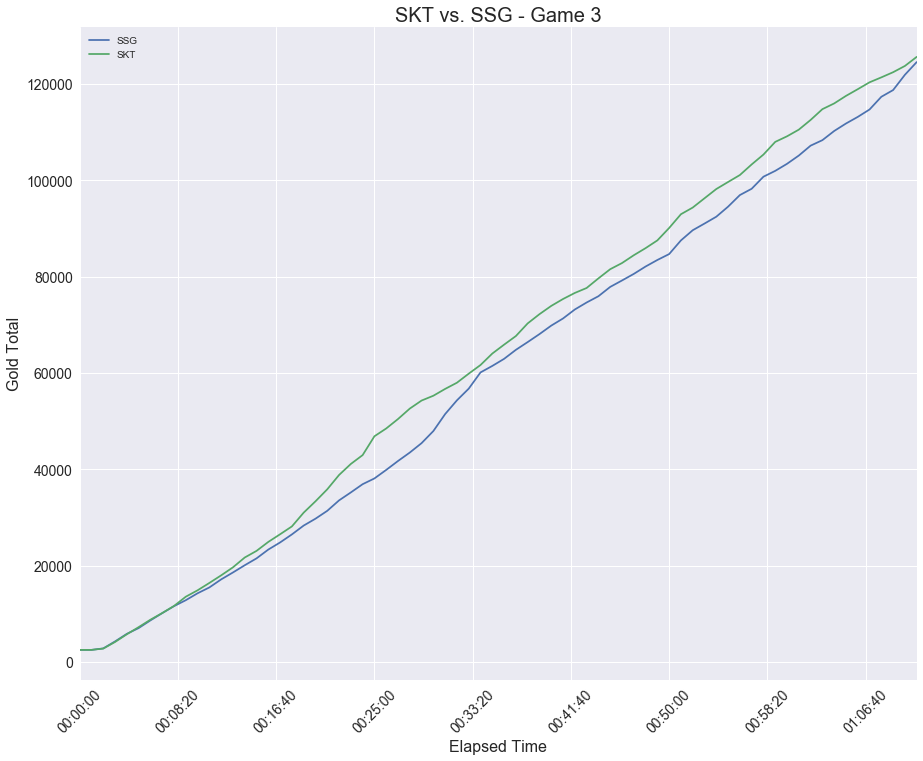

In [668]:
# create plot
game3.plot(figsize=(15,12))
plt.title("SKT vs. SSG - Game 3",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(rotation=45)
plt.xlabel("Elapsed Time", fontsize=16)
plt.ylabel("Gold Total", fontsize=16);

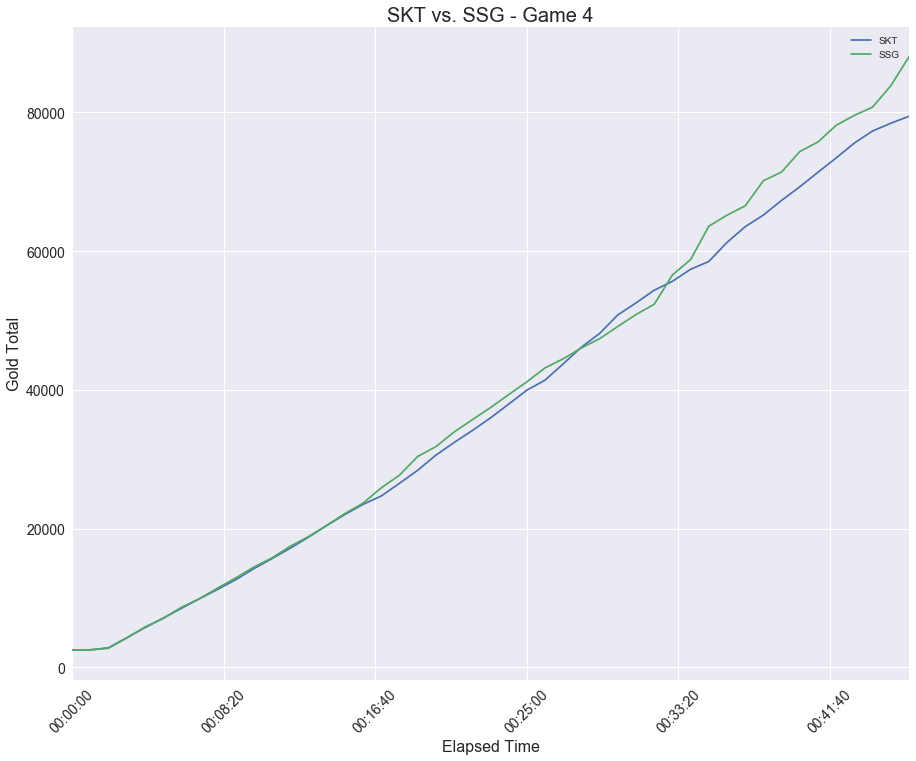

In [667]:
# create plot
game4.plot(figsize=(15,12))
plt.title("SKT vs. SSG - Game 4",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(rotation=45)
plt.xlabel("Elapsed Time", fontsize=16)
plt.ylabel("Gold Total", fontsize=16);

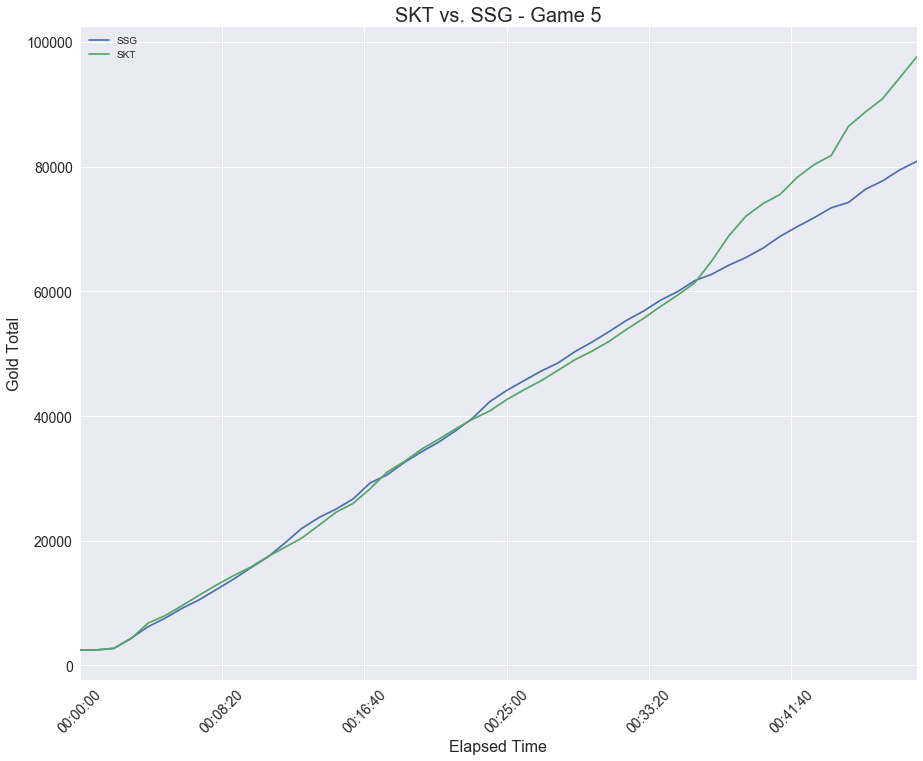

In [666]:
# create plot
game5.plot(figsize=(15,12))
plt.title("SKT vs. SSG - Game 5",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(rotation=45)
plt.xlabel("Elapsed Time", fontsize=16)
plt.ylabel("Gold Total", fontsize=16);